In [50]:
# Initialize Otter
import otter
grader = otter.Notebook("projB1.ipynb")

# Project B.1: Spam/Ham Classification

You must submit this assignment to Gradescope by the on-time deadline, Thursday, April 20th, 11:59 PM. 
Please read the syllabus for the grace period policy. 
No late submissions beyond the grace period will be accepted. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to last-minute requests for assistance (TAs need to sleep, after all!). 
**We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** 
This way, you will have ample time to reach out to staff for submission support.

### Collaboration Policy

Data science is a collaborative activity. 
While you may talk with others about this project, we ask that you **write your solutions individually**. 
If you do discuss the assignments with others please **include their names** in the collaborators cell below.

**Collaborators**: *list collaborators here*

## Introduction
You will use what you've learned in class to create a binary classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data,
- Using `sklearn` library to process data and fit models, and
- Validating the performance of your model and minimizing overfitting.

This first part of the project focuses on initial analysis as well as Feature Engineering and Logistic Regression. In the second part of this project (to be released next week),  you will build your own spam/ham classifier.

## Content Warning
This is a **real world** dataset – the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these innapropriate emails, and wanted to give a warning at the beginning of the project so that you are made aware.

If you feel uncomfortable with this topic, **please contact your GSI or the instructors, or reach out via the Spring 2023 extenuating circumstances form.**

In [51]:
# Run this cell to suppress all FutureWarnings.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# More readable exceptions.
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.
The iwut extension is already loaded. To reload it, use:
  %reload_ext iwut


## Grading
Grading is broken down into autograded answers and free response. 

For autograded answers, the results of your code are compared to provided and/or hidden tests.

For free response, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question.

Question | Manual | Points
----|----|----
1 | Yes | 2
2 | No | 3
3 | Yes | 3
4 | No | 2
5 | No | 2
6a | No | 1
6b | No | 1
6c | Yes | 2
6d | No | 2
6e | Yes | 1
6f | Yes | 1
6g | Yes | 1
6h | Yes | 1
Total | 7 | 22

In [52]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/). It consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

**Note:** The dataset is from 2004, so the contents of emails might be very different from those in 2023.

Run the following cells to load the data into a `DataFrame`.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` DataFrame contains 1,000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [53]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [54]:
# Loading training and test datasets
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


First, let's check if our data contains any missing values. We have filled in the cell below to print the number of `NaN` values in each column. If there are `NaN` values, we replace them with appropriate filler values (i.e., `NaN` values in the `subject` or `email` columns will be replaced with empty strings). Finally, we print the number of `NaN` values in each column after this modification to verify that there are no `NaN` values left.

**Note:** While there are no `NaN` values in the `spam` column, we should be careful when replacing `NaN` labels. Doing so without consideration may introduce significant bias into our model.

In [55]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 1: Initial Analysis

In the cell below, we have printed the text of the `email` field for the first ham and the first spam email in the original training set.

In [56]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



<!-- BEGIN QUESTION -->

<br><br>

---

## Question 1

Discuss one attribute or characteristic you notice that is different between the two emails that might relate to the identification of a spam email.

The spam email has some html code in it. The ham email has none of that code in its text, while the spam email also has some of those characteristics in its text. 

<!-- END QUESTION -->

## Training-Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (`random_state`) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this random seed in the following questions, as our tests depend on it.**

In [57]:
# This creates a 90/10 train-validation split on our labeled data.

from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 2: Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a **binary classification** problem, so we can use logistic regression to train a classifier. Recall that to train a logistic regression model we need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $Y$. Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $\mathbb{X}$ is an email. Each column of $\mathbb{X}$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones as you try to increase the accuracy of your model.

<br><br>

---

## Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas `Series` of email `texts`. It should output a 2-dimensional `NumPy` array containing one row for each email text. The row contains 0 or 1 values associate with each word in the `words` list. If j-th word in the `words` exists in the i-th input of the email `texts` Series, the output element at index (i, j) will be 1, otherwise it will be 0. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*


In [58]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, p) where 
        n is the number of texts and p is the number of words.
    """
    lst = []
    for word in words:
        lst.append(texts.str.contains(word).astype(int))
    indicator_array = np.array(lst).T
    return indicator_array

In [59]:
grader.check("q2")

q2 results: All test cases passed!

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 3: Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.

The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](images/training_conditional_proportions.png)

You can use DataFrame's `.melt` ([documentation](https://pandas.pydata.org/pandas-docs/version/1.4/reference/api/pandas.melt.html)) method to "unpivot" a DataFrame. See the following code cell for an example.

In [60]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurences of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column."))
display(df.melt("type"))

> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurences of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column.

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


<br><br>

---

## Question 3

Create the bar chart above by comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

**Hint:** One way you can do this is with `sns.barplot`. Take a look at the ([documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html)) and determine what the inputs should be. A possible data input is given below:
<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>type</th>      <th>variable</th>      <th>value</th>    </tr>  </thead>  <tbody>    
<tr>      <th>0</th>      <td>Ham</td>      <td>word_1</td>      <td>0.021269</td>    </tr>    
<tr>      <th>1</th>      <td>Ham</td>      <td>word_2</td>      <td>0.101519</td>    </tr>    
<tr>      <th>2</th>      <td>Spam</td>      <td>word_3</td>      <td>0.059160</td>    </tr>    
<tr>      <th>3</th>      <td>Spam</td>      <td>word_2</td>      <td>0.017694</td>    </tr>    
<tr>      <th>4</th>      <td>Ham</td>      <td>word_1</td>      <td>0.013226</td>    </tr>     
<tr>      <th>...</th>      <td>...</td>      <td>...</td>      <td>...</td>    </tr>    
</tbody></table>

<!-- BEGIN QUESTION -->

Create your bar chart with the following cell:

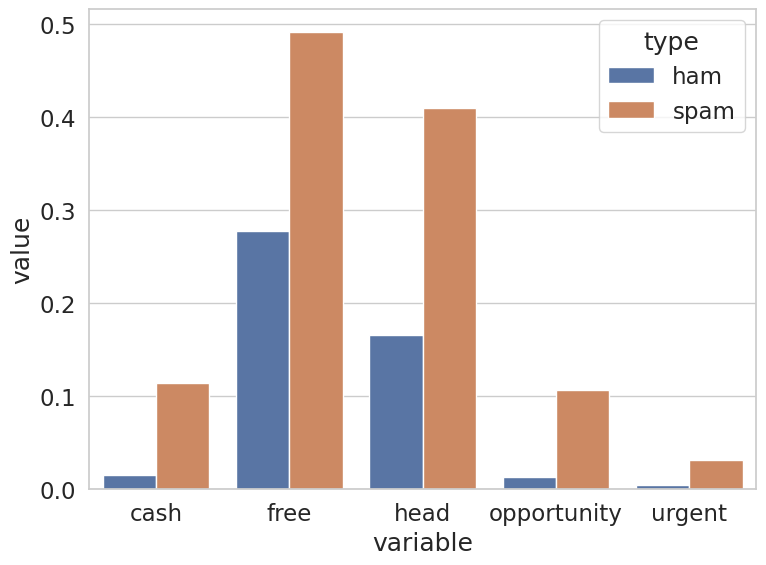

In [61]:
train = train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
plt.figure(figsize=(8,6))
my_words = ['cash', 'free', 'head', 'opportunity', 'urgent']
dist = pd.DataFrame(words_in_texts(my_words, train['email']), 
                    columns=my_words)
dist['type'] = train['spam']
dist = dist.replace({'type' : {0:'ham',
                        1:'spam'}})
melted_dist = dist.melt('type')
lens_arr = melted_dist.groupby(['type', 'variable']).count().reset_index()['value']
distributions = melted_dist.groupby(['type', 'variable']).count().reset_index()
distributions['value'] = melted_dist.groupby(['type', 'variable']).sum().reset_index()['value']/lens_arr
distributions

sns.barplot(data=distributions, x='variable', y='value', hue='type')

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 4: Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

<br><br>

---

## Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix ($\mathbb{X}$) are correct, and that your features and labels are binary (i.e. consists of only 0's and 1's). It does not check that your function is correct; that was verified in a previous question.*

In [62]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [63]:
grader.check("q4")

q4 results: All test cases passed!

<br><br>

---
## Question 5

Now that we have matrices, we can build a model with `sklearn`! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the model's training accuracy below. You should get an accuracy of around $0.75$.

*The provided test checks that you initialized your logistic regression model correctly.*


In [64]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train) 

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [65]:
grader.check("q5")

q5 results: All test cases passed!

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Part 5: Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as the accuracy would make you believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). In future parts of this analysis, we will hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False positive (FP)**: a ham email gets flagged as spam and filtered out of the inbox.
- **False negative (FN)**: a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision**: Measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall**: Measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False positive rate**: Measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The below graphic (modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)) may help you understand precision and recall visually:<br />
<center>
<img alt="precision_recall" src="images/precision_recall.png" width="600px" />
</center>

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br><br>

---

## Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (feel free to hard code your answers for this part):

*Tests in Question 6 only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct.*

In [76]:
zero_predictor_fp = 0
zero_predictor_fn = sum(Y_train)

zero_predictor_fp, zero_predictor_fn

(0, 1918)

In [77]:
grader.check("q6a")

q6a results: All test cases passed!

<br><br>

---

## Question 6b

What is the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do **NOT** use any `sklearn` functions.

In [78]:
zero_predictor_acc = (len(Y_train) - sum(Y_train))/len(Y_train)
zero_predictor_recall = 0 / (0 + zero_predictor_fn)
zero_predictor_acc, zero_predictor_recall

(0.7447091707706642, 0.0)

In [69]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br><br>

---

## Question 6c

Comment on the results from 6a and 6b. For **each** of FP, FN, accuracy, and recall, briefly explain why we see the result that we do.

_The number of false positives is zero because everything gets marked as negative in our model, thus there's no chance for something to be marked as positive. Since our model predicts all negatives, that means the number of false negatives will be the total number of emails what were actually positive from the data. Accuracy reflects the percentage of of points that were correctly classified which in this case would all the ham emails. Recall reflects how many spam emails were classified correctly ans since all we predicted are negatives, no spam email was classified correctly._

<!-- END QUESTION -->

<br/><br/>

---

## Question 6d

Compute the precision, recall, and false positive rate of the `LogisticRegression` classifier created and trained in Question 5. Do **NOT** use any `sklearn` functions, with the exception of the `.predict` method of your model object.


In [74]:
y_pred = model.predict(X_train)
confusion_lst = []
for i in range(len(y_pred)):
        if Y_train[i] == 0 and y_pred[i] == 0:
            confusion_lst.append('TN')
        if Y_train[i] == 0 and y_pred[i] == 1:
            confusion_lst.append('FP')
        if Y_train[i] == 1 and y_pred[i] == 0:
            confusion_lst.append('FN')
        if Y_train[i] == 1 and y_pred[i] == 1:
            confusion_lst.append('TP')
confusion_arr = np.array(confusion_lst)
TP = sum(confusion_arr == 'TP')
TN = sum(confusion_arr == 'TN')
FP = sum(confusion_arr == 'FP')
FN = sum(confusion_arr == 'FN')

logistic_predictor_precision = TP / (TP + FP)
logistic_predictor_recall = TP / (TP + FN)
logistic_predictor_fpr = FP / (FP + TN)

print(f"{TP=}, {TN=}, {FP=}, {FN=}")
print(f"{logistic_predictor_precision=:.2f}, {logistic_predictor_recall=:.2f}, {logistic_predictor_fpr=:.2f}")

TP=219, TN=5473, FP=122, FN=1699
logistic_predictor_precision=0.64, logistic_predictor_recall=0.11, logistic_predictor_fpr=0.02


In [75]:
grader.check("q6d")

q6d results: All test cases passed!

<!-- BEGIN QUESTION -->

<br><br>

---

## Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Question 5? Take a look at your result in 6d!


_There are more false negatives than false postives when using the the logistic regression classifier._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---

## Question 6f

Our logistic regression classifier got 75.76% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?

This is a little better but still very similar than the model prediciting 0 for every email since there's roughly a ~1% improvement in our accuracy. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---

## Question 6g

Given the word features we gave you above, name one reason this classifier is performing poorly. **Hint:** Think about how prevalent these words are in the email set.

_This may be happening because the word features that were given to us do not have a significant difference in the proportion of times that are ocurring in each set of spam and ham emails.These words may be prevalent at similar rates in each set._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---

## Question 6h

Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.


_I would prefer to use the logistic regression classifier given that it has a higher recall rate than the the model that predicts 0. Since I want to find out whether an email is spam or not, I would prefer to use the model that provides me better insight. The model that predicts all negatives would not alert me if an email is spam ever._

<!-- END QUESTION -->

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Congratulations! You have finished Project B.1!

What's next? In Project B.2, you will focus on building a spam/ham email classifier with logistic regression. You will be well-prepared to build such a model: you have considered what is in this data set, what it can be used for, and engineered some features that should be useful for prediction.

Below, you will see two cells. Running the first cell will automatically generate a PDF of all questions that need to be manually graded, and running the second cell will automatically generate a zip with your autograded answers. **You are responsible for both the coding portion (the zip from Project B.1) and the written portion (the PDF from Project B.1) to their respective Gradescope portals.** The coding proportion should be submitted to Project B.1 Coding as a single zip file, and the written portion should be submitted to Project B.1 Written as a single pdf file. When submitting the written portion, please ensure you select pages appropriately. 

If there are issues with automatically generating the PDF in the first cell, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. Either way, **you are responsible for ensuring your submission follows our requirements, we will NOT be granting regrade requests for submissions that don't follow instructions.**

In [ ]:
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("projB1.ipynb", filtering=True, pagebreaks=True)
if(path.exists('projB1.pdf')):
    display(HTML("Download your PDF <a href='projB1.pdf' download>here</a>."))
else:
    print("\n Pdf generation fails, please try the other methods described above")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)